# Graph Classification 
### This file contains code relating to the graph classification task and generation of explanations

## Installation

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
!pip install ipdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 793 kB 6.7 MB/s 
     |████████████████████████████████| 1.6 MB 41.6 MB/s 
  Created wheel for ipdb: filename=ipdb-0.13.9-py3-none-any.whl size=11649 sha256=882ffbffca15a219418450623425e94283347eecad92b6457c062c7acf034c87
  Stored in directory: /root/.cache/pip/wheels/65/cd/cc/aaf92acae337a28fdd2aa4d632196a59745c8c39f76eaeed01
Successfully built ipdb
  Attempting uninstall: ipython
    Found existing installation: ipython 7.9.0
    Uninstalling ipython-7.9.0:
      Successfully uninstalled ipython-7.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython~=7.9.0, but you have ipython 7.34.0 which is incompatible.


In [ ]:
!pip install --verbose --no-cache-dir torch-scatter
!pip install --verbose --no-cache-dir torch-sparse
!pip install --verbose --no-cache-dir torch-cluster
!pip install torch-geometric
!pip install tensorboardX
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
!pip install pgmpy

In [1]:
!git clone https://github.com/YANI-ALT/FML-GNN_DisagreementProblem.git

Cloning into 'FML-GNN_DisagreementProblem'...
remote: Enumerating objects: 15782, done.
remote: Counting objects: 100% (15782/15782), done.
remote: Compressing objects: 100% (716/716), done.
remote: Total 15782 (delta 15074), reused 15716 (delta 15026), pack-reused 0
Receiving objects: 100% (15782/15782), 39.88 MiB | 9.96 MiB/s, done.
Resolving deltas: 100% (15074/15074), done.
Checking out files: 100% (25301/25301), done.


In [14]:
cd FML-GNN_DisagreementProblem/

[Errno 2] No such file or directory: 'FML-GNN_DisagreementProblem/'
/content/FML-GNN_DisagreementProblem/GNNModels


In [3]:
cd GraphXAI-main/

/content/FML-GNN_DisagreementProblem/GraphXAI-main


In [4]:
pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/FML-GNN_DisagreementProblem/GraphXAI-main
  Running setup.py develop for graphxai


In [187]:
cd ../GNNModels/

/content/FML-GNN_DisagreementProblem/GNNModels


In [188]:
# cd FML-GNN_DisagreementProblem/GNNModels/

In [189]:
# cd GraphXAI-main/

In [190]:
# cd FML-GNN_DisagreementProblem/GraphXAI-main/

In [191]:
# pip install -e .

In [192]:
# cd ../GNNModels

## Code starts here

In [193]:
#Notebook starts from here

In [16]:
import torch
from Models import *
from Train import *
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.datasets import TUDataset
import matplotlib.pyplot as plt
import pickle
import datetime 
from tqdm import tqdm

In [287]:
cd ../GNNModels/

/content/FML-GNN_DisagreementProblem/GNNModels


In [288]:
# ls

In [289]:
# model_name = 'GCN_3L'
model_name = 'GNNGraphConv'
dataset_name = 'PROTEINS'
dataset = TUDataset(root='data/TUDataset', name=dataset_name)
model = get_model_pretrained(model_name=model_name,dataset_name=dataset_name)

In [290]:
# model = GCN_3L(hidden_channels=64,num_features=dataset.num_node_features,num_classes=dataset.num_classes)

# # params={'lr':0.01,'epochs':10,'verbose':True,'save_wts':''}
# params={'lr':0.01,'epochs':50,'verbose':True,'save_wts':'checkpoints/GCN_3L_PROTEINS_epochs=300.pt'}

# TrainModel(model,dataset,params,type='GC')

In [291]:
cd ../GraphXAI-main/

/content/FML-GNN_DisagreementProblem/GraphXAI-main


In [292]:
model

GNNGraphConv(
  (conv1): GraphConv(3, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)

In [293]:
from graphxai.explainers import GNNExplainer, IntegratedGradExplainer, PGExplainer, CAM, PGMExplainer, GradCAM

### Build Explainers

In [300]:
gnex = GNNExplainer(model)
igex = IntegratedGradExplainer(model, criterion=torch.nn.CrossEntropyLoss())
pgm = PGMExplainer(model, explain_graph=True)

### Helper functions to extract imp nodes

In [312]:
def gnn_imp_nodes(dataset_idx):
  
  gnex_ne = gnex.get_explanation_graph(dataset[dataset_idx].x, dataset[dataset_idx].edge_index, forward_kwargs={'batch':None})

  imp_nodes = []
  for i, j in enumerate(gnex_ne.node_imp.numpy()):
    if int(j) == 1:
      imp_nodes.append(i)
  return imp_nodes

def pge_imp_nodes(dataset_idx):

    pgex_ne = pgex.get_explanation_graph(dataset[dataset_idx].x, dataset[dataset_idx].edge_index, forward_kwargs={'batch':None})

    imp_nodes = []

    for i, j in enumerate(pgex_ne.node_imp.numpy()):
      if int(j) == 1:
        imp_nodes.append(i)
    return imp_nodes

def cam_imp_nodes(dataset_idx):

    cam_ne = cam.get_explanation_graph(dataset[dataset_idx].x, dataset[dataset_idx].edge_index, forward_kwargs={'batch':None})

    imp_nodes = []
    ranking = []

    cam_ne_norm = torch.sigmoid(cam_ne.node_imp)

    for i, j in enumerate(cam_ne_norm.numpy()):
      if j > 0.5:
        imp_nodes.append(i)
        ranking.append(cam_ne_norm[i])

    return imp_nodes, ranking

def Gradcam_imp_nodes(dataset_idx):

    Gradcam_ne = Gradcam.get_explanation_graph(dataset[dataset_idx].x, dataset[dataset_idx].edge_index, forward_kwargs={'batch':None})

    imp_nodes = []
    ranking = []

    Gradcam_ne_norm = torch.sigmoid(Gradcam_ne.node_imp)

    for i, j in enumerate(Gradcam_ne_norm.numpy()):
      if j > 0.5:
        imp_nodes.append(i)
        ranking.append(Gradcam_ne_norm[i])

    return imp_nodes, ranking

def ig_imp_nodes(dataset_idx):

    igex_ne = igex.get_explanation_graph(dataset[dataset_idx].edge_index, dataset[dataset_idx].x, dataset[dataset_idx].y, forward_kwargs={'batch':None})
    imp_nodes = []
    ranking = []

    igex_ne_norm = torch.sigmoid(igex_ne.node_imp)

    for i, j in enumerate(igex_ne_norm.detach().numpy()):
      if j > 0.5:
        imp_nodes.append(i)
        ranking.append(igex_ne_norm[i])


    return imp_nodes, ranking

def pgm_imp_nodes(dataset_idx):
  import numpy as np
  np.random.seed(1998)
  pgm_ne = pgm.get_explanation_graph(dataset[dataset_idx].x, dataset[dataset_idx].edge_index, forward_kwargs={'batch':None})

  imp_nodes = []
  for i, j in enumerate(pgm_ne.node_imp.numpy()):
    if j == 1:
      imp_nodes.append(i)
  return imp_nodes

In [316]:
torch.manual_seed(12345)
data = dataset.shuffle()
split=int(0.6*len(data))
train_dataset = dataset[:split]
test_dataset = dataset[split:]

### Get The Important Nodes

In [321]:
imp_nodes_ig = {}
imp_nodes_ig_ranking = {}
imp_nodes_gnn = {}
imp_nodes_pge = {}
imp_nodes_pgm = {}
imp_nodes_cam = {}
imp_nodes_cam_ranking = {}
imp_nodes_Gradcam = {}
imp_nodes_Gradcam_ranking = {}
graph_indices = []

num_datasets = len(test_dataset)

for i in tqdm(range(num_datasets)):

  out = model(test_dataset[i].x, test_dataset[i].edge_index, test_dataset[i].batch)
  if out.argmax() != test_dataset[i].y:
    continue
  
  graph_indices.append(i)
  imp_nodes_gnn[i] = gnn_imp_nodes(i)
  # imp_nodes_pge[i] = pge_imp_nodes(i)
  # imp_nodes_cam[i], imp_nodes_cam_ranking[i] = cam_imp_nodes(i)
  imp_nodes_pgm[i] = pgm_imp_nodes(i)
  imp_nodes_ig[i], imp_nodes_ig_ranking[i] = ig_imp_nodes(i)
  # imp_nodes_Gradcam[i], imp_nodes_Gradcam_ranking[i] = Gradcam_imp_nodes(i)

100%|██████████| 446/446 [03:49<00:00,  1.94it/s]


Metrics Calculation

In [324]:
def jaccard(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection

    if union == 0:
        return float(1)
        
    return float(intersection) / union

In [328]:
import numpy as np
n_methods = 3

jacard = np.zeros((n_methods, n_methods))

count = 0
for k in imp_nodes_ig.keys():

    count += 1

    # jacard[0, 1] += jaccard(imp_nodes_ig[k], imp_nodes_gnn[k])
    # jacard[0, 2] += jaccard(imp_nodes_ig[k], imp_nodes_pge[k])
    # jacard[0, 3] += jaccard(imp_nodes_ig[k], imp_nodes_cam[k])
    # jacard[0, 4] += jaccard(imp_nodes_ig[k], imp_nodes_pgm[k])
    # jacard[0, 5] += jaccard(imp_nodes_ig[k], imp_nodes_Gradcam[k])

    jacard[0, 1] += jaccard(imp_nodes_ig[k], imp_nodes_gnn[k])
    jacard[0, 2] += jaccard(imp_nodes_ig[k], imp_nodes_pgm[k])
  
    # jacard[1, 2] += jaccard(imp_nodes_gnn[k], imp_nodes_pge[k])
    # jacard[1, 3] += jaccard(imp_nodes_gnn[k], imp_nodes_cam[k])
    # jacard[1, 4] += jaccard(imp_nodes_gnn[k], imp_nodes_pgm[k])
    # jacard[1, 5] += jaccard(imp_nodes_gnn[k], imp_nodes_Gradcam[k])

    jacard[1, 2] += jaccard(imp_nodes_gnn[k], imp_nodes_pgm[k])

    # jacard[2, 3] += jaccard(imp_nodes_pge[k], imp_nodes_cam[k])
    # jacard[2, 4] += jaccard(imp_nodes_pge[k], imp_nodes_pgm[k])
    # jacard[2, 5] += jaccard(imp_nodes_pge[k], imp_nodes_Gradcam[k])

    # jacard[3, 4] += jaccard(imp_nodes_cam[k], imp_nodes_pgm[k])
    # jacard[3, 5] += jaccard(imp_nodes_cam[k], imp_nodes_Gradcam[k])

    # jacard[4, 5] += jaccard(imp_nodes_pgm[k], imp_nodes_Gradcam[k])


jacard = (jacard + jacard.T)/(count)

for i in range(n_methods):

    jacard[i,i] = 1
    

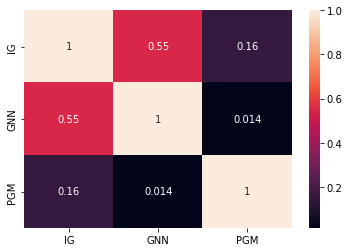

In [330]:
import seaborn as sns
import pandas as pd
labels = ["IG", "GNN","PGM"]
jacard_df = pd.DataFrame(jacard, index = labels, columns = labels)
sns.heatmap(jacard_df, annot=True)

In [331]:
# define dictionary
expl_to_save = {'graph_indices':graph_indices,
        'ig' : imp_nodes_ig, 
        'gnn' : imp_nodes_gnn, 
        'pge' : imp_nodes_pge,
        'pgm':imp_nodes_pgm,
        'cam':imp_nodes_cam, 
        'gcam': imp_nodes_Gradcam}

# create a binary pickle file 

now = datetime.datetime.now()
timestamp_str=now.strftime('%Y-%m-%dT%H:%M:%S') + ('-%02d' % (now.microsecond / 10000))

In [332]:
# define dictionary
rank_to_save = {'graph_indices':graph_indices,
        'ig' : imp_nodes_ig_ranking,
        'cam':imp_nodes_cam_ranking, 
        'gcam': imp_nodes_Gradcam_ranking}

# create a binary pickle file 

now = datetime.datetime.now()
timestamp_str=now.strftime('%Y-%m-%dT%H:%M:%S') + ('-%02d' % (now.microsecond / 10000))

In [333]:
cd ../GNNModels/

/content/FML-GNN_DisagreementProblem/GNNModels


## Saving explanation as pickle

In [334]:
with open("Saved_Explanations/Explanations_{}_{}_{}.pkl".format(model_name,dataset_name,timestamp_str),"wb") as f:
    # write the python object (dict) to pickle file
    pickle.dump(expl_to_save,f)

In [335]:
with open("Saved_Explanations/Rankings_{}_{}_{}.pkl".format(model_name,dataset_name,timestamp_str),"wb") as f:
    # write the python object (dict) to pickle file
    pickle.dump(rank_to_save,f)